In [1]:
import numpy as np 
import sys 
import matplotlib.pyplot as plt
import time
import scipy.stats as st
import scipy.cluster.vq as cvq
import multiprocessing as mp
import image_tools as it
from scipy.ndimage import imread


import numpy.ma as ma
import scipy.stats as st
import scipy.signal as si
from astropy.io import fits
from astropy.table import Table
import scipy.ndimage.morphology as morph
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
%reload_ext autoreload

import parameters
#import image_tools as it
import gibbs_sampler as gs
import fields_tools as ft
import seg_OTMF as sot

sys.path.insert(0,'./libext/MPDAF')
import mpdaf

from mpdaf.obj import WCS
from mpdaf.obj import WaveCoord
from mpdaf.obj import Image
from mpdaf.obj import Spectrum
from mpdaf.obj import Cube


from mpdaf.sdetect import Source, SourceList
from mpdaf.sdetect import Catalog

In [2]:
# recup catalogue

cat = Catalog.read('./data/mosaic_lya_sources/mosaic_c031_e028_withz.fits')

cat_lya=cat[cat['TYPE']==6]

print 'Total de %.0f LAE dans la mosaïque.'%len(cat_lya)

Total de 745 LAE dans la mosaïque.


/home/miv/courbot/anaconda/lib/python2.7/site-packages/astropy/table/column.py:1095: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [3]:
liste_restrict = (63,   68,   82,  102,  109,  126,  148,  153,  168,  171,  183, 214,  218,  262,  263,  298,
            299,  324,  364,  399,  400,  489, 579,  587,  590,  606,  619,  736, 1059, 1087, 1113, 1228,
            1445, 1446, 1477, 1478, 1486, 1581, 1583, 1593, 1665, 1670, 1711, 1714, 1723, 1724, 1726, 1737,
            1756, 1843, 1864, 1931, 1969, 1971, 1991, 2049, 2103, 2132, 2155, 2171, 2178, 2211, 2217, 2264,
            2333, 2335, 2363, 2389, 2403, 2467, 2495, 2515, 2522, 2547, 2598, 2634, 2672, 2687, 2727, 2733,
            2817, 2847, 2861, 2865, 2885, 3027, 3055, 3089, 3138, 3156, 3219, 3234, 3238, 3240, 3242, 3257,
            3286, 3305, 3329, 3335, 3421, 3426, 3480, 3484, 3492, 3494, 3585, 3589, 3611, 3634, 3672, 3723,
            3746, 3797, 3858, 3930, 3933, 3946, 4141, 4205, 4231, 4333, 4381, 4515, 4598, 4661, 4755, 4776,
            4802, 4842, 4870, 5027, 5225, 5281, 5308, 5439, 5452, 5566, 5949, 6101, 6341, 6372, 6375, 6376,
            6389, 6391, 6398, 6423, 6430, 6447, 6457, 6458, 6459, 6483, 6485, 6489, 6492, 6497, 6507, 6520,
            6537, 6550, 6565, 6570, 6572, 6578)

print 'Total de %.0f objets retenus dans la mosaïque.'%len(liste_restrict)

Total de 166 objets retenus dans la mosaïque.


In [4]:
cube = Cube('./data/DATACUBE_UDF-MOSAIC.fits')

#cat_fits = fits.open('./data/Catalog_HDFS_v1p0.fits',memmap=True)

In [17]:
im_rgb = np.zeros(shape=(1000,1000,3))

for x in (0,200,400,600,800):
    for y in (0,200,400,600,800):
        
        print x,y
        
        debx,deby = x,y
        if x == 800:
            finx = 947
        else:
            finx = x+200
            
        if y == 800:
            finy = 945
        else:
            finy = y+200
            
        
        sous_cube = cube.data[:,debx:finx,deby:finy]
        
        im_r = sous_cube[:1220,:,:].mean(axis=0)
        im_g = sous_cube[1220:2440,:,:].mean(axis=0)
        im_b = sous_cube[2440:,:,:].mean(axis=0)
        
        im_rgb[debx:finx,deby:finy,0] = im_r
        im_rgb[debx:finx,deby:finy,1] = im_g
        im_rgb[debx:finx,deby:finy,2] = im_b
        
        


0 0
0 200
0 400
0 600
0 800
200 0
200 200
200 400
200 600
200 800
400 0
400 200
400 400
400 600
400 800
600 0
600 200
600 400
600 600
600 800
800 0
800 200
800 400
800 600
800 800


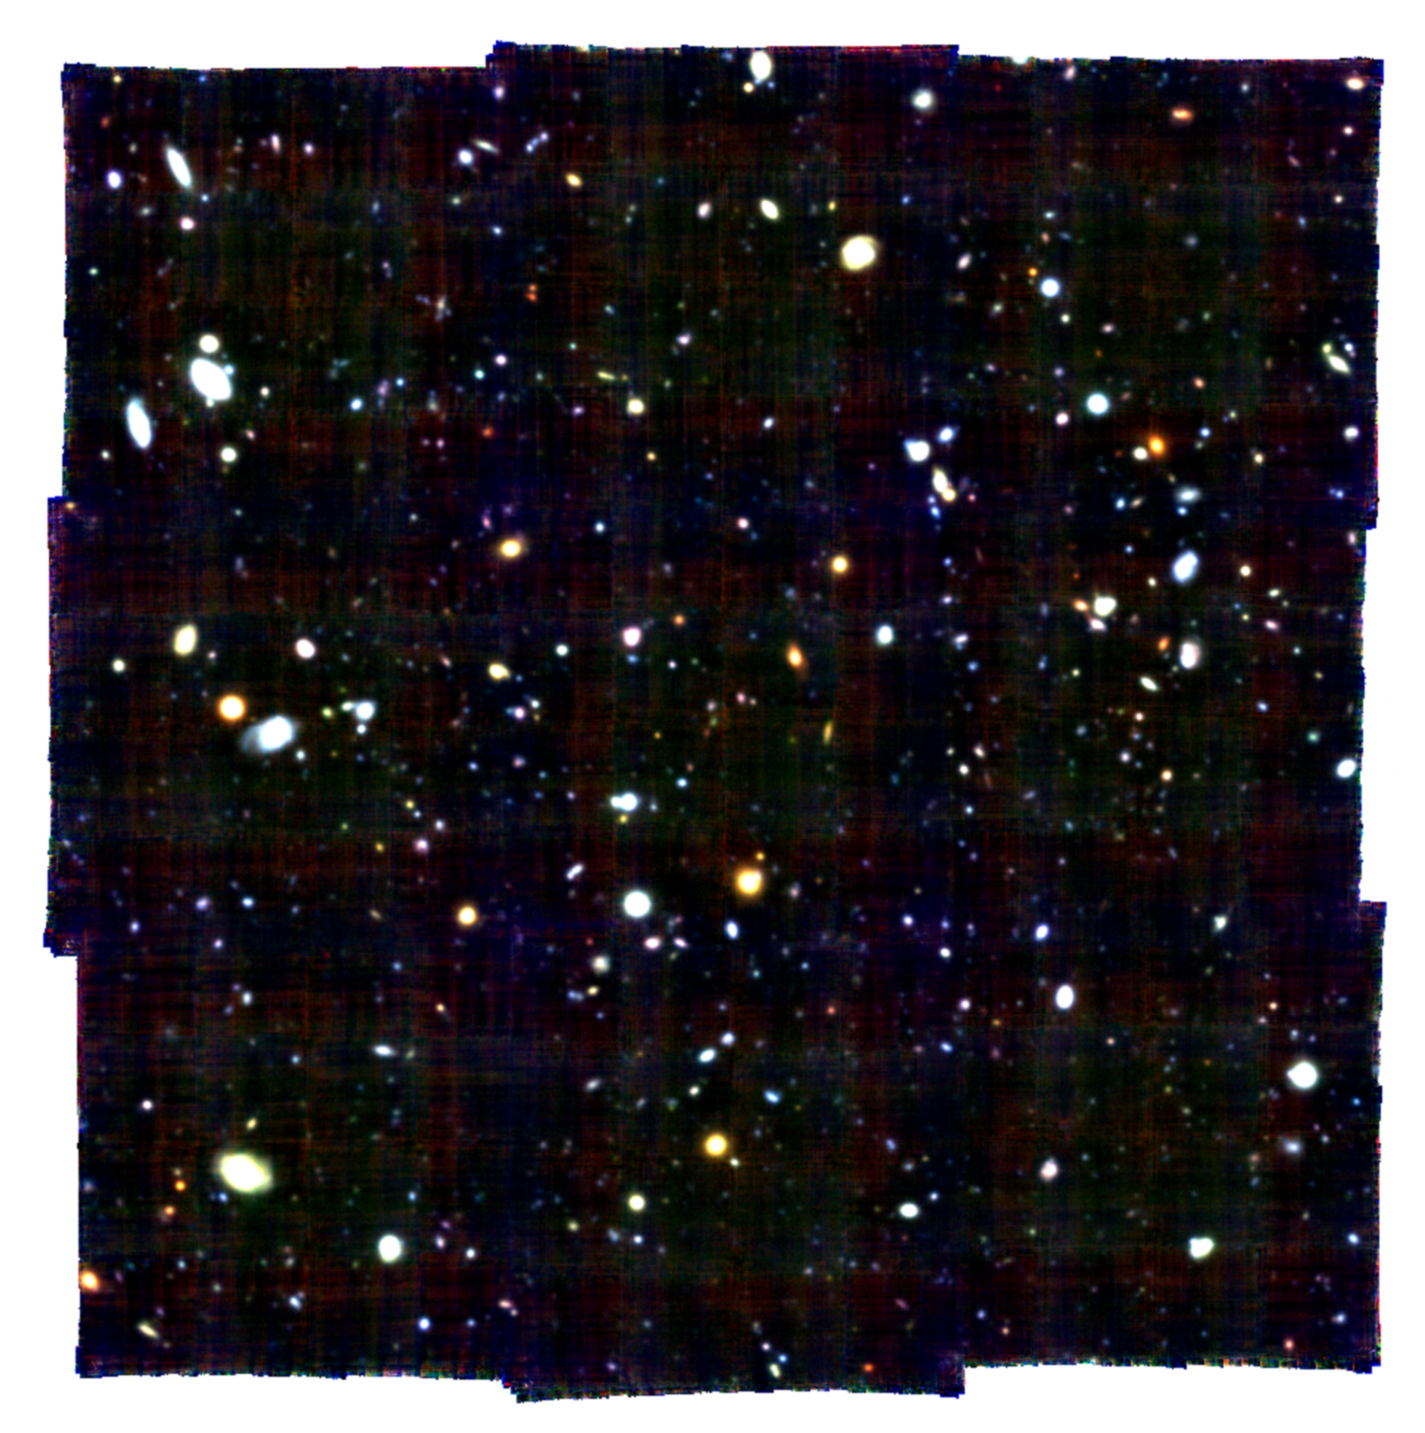

In [89]:
from matplotlib.colors import LogNorm

im = np.copy(im_rgb)
msk = np.tile((im_rgb.sum(axis=2)==0)[:,:,np.newaxis], (1,1,3))
im[im< 0] = 0

im[:,:,0] /= 1.5#im[:,:,0].max()
im[:,:,1] /= 1.5#im[:,:,1].max()
im[:,:,2] /= 1.5#im[:,:,2].max()



im[im>1.0] = 1
im[msk] = 1


plt.figure(figsize=(20,20))
plt.imshow(im[:957,:945,::-1],origin='lower',interpolation='bicubic')
plt.axis('off')
plt.tight_layout()
plt.savefig('mosaic_color.png',dpi=200)

In [80]:
np.tile((im_rgb.sum(axis=2)==0)[:,:,np.newaxis], (1,1,3)).shape

(1000, 1000, 3)

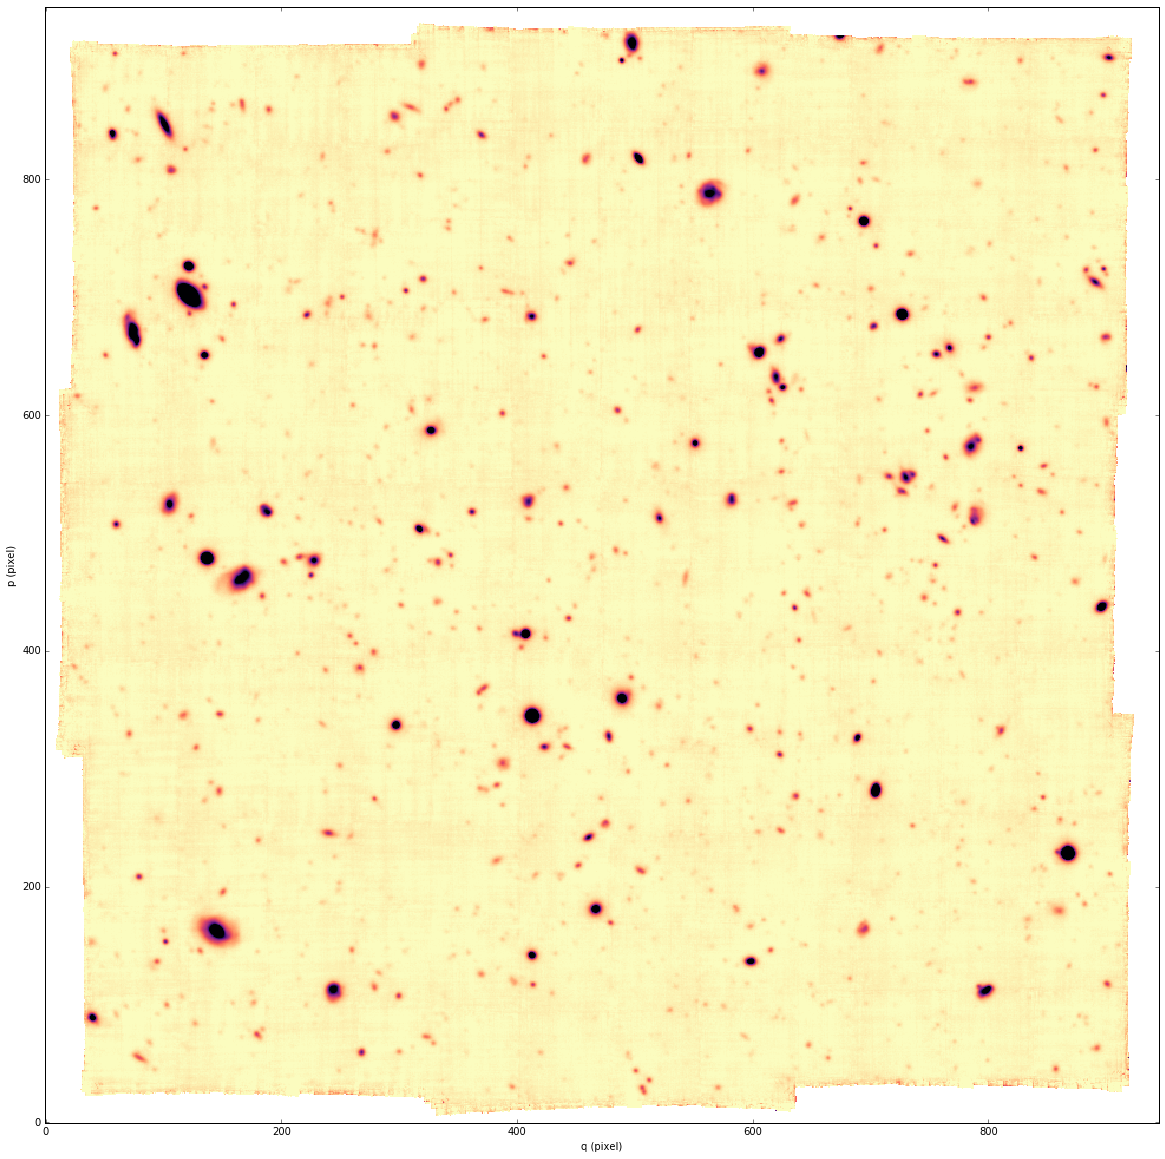

In [73]:
cat_lya=cat[cat['TYPE']==6]

im = Image('data/IMAGE_UDF-MOSAIC.fits')
#id_nobor = np.abs(cat_lya.edgedist(wcs=im.wcs))>25*0.2
fig = plt.figure(figsize=(20,20))
ax = plt.subplot(1,1,1)

im.plot(vmin=0,vmax=5,cmap='magma_r')
#cat.plot_id(ax,im.wcs)
#cat_lya.plot_id(ax,im.wcs,col='blue')





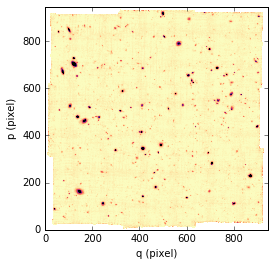

In [78]:
import astropy.units as u

im.plot(vmin=0,vmax=5,cmap='magma_r',unit=u.deg)

In [79]:
#liste_50 = (364,400,590,736,1446,1714)

#liste_50 = (1737,1756, 1843,1864,1969,1971,1991,2155,2171,2178,2217,2335,2467,2515,2547,2598,2634,2727,2885,)


#liste_40 = (1583,1593, 736,590,1446,3219,3242,3286,3305,3242,3492,3494,3589,3611,3672,3723,3746,3797,3858,3946,4141,1991,2178,1843,2217)

#liste_lam_court = (399,579,587,1670,1723,1724,2132,2264,2403,3089,3238,3634,3930,6101,6457,6507, 3305,)

#liste_40 = (4802,5439,5452,6341,6375,6376,6389,6423,6430,6447,6483,6489,6492,6520,6550,6565, 399,579,587,1723,1724,2132,)



#liste_50=(3257,3426,4205,4515,4598,4755,4776,5225,
#          5308, 3219,4141,3286,3634,6376,1724,364,1726,)

#liste_100=(68,324,364,1726,2817,1670,2132,)
#liste_70 = (171,1478,1581,2672,2687,68,2817)

#liste_100 = (1670,2132,1726)
liste_50 = (364,1726,6101,3305)
#liste_70=(68,2817)
liste_40 = (3257,4755,5225,3219,4141,6376,1478,)

#liste_lam_10 = (4333,)
liste_lam_plus = (6101,3305,168)

liste_echec = (606,1665,2103,2847,3138,3156,3234,3240,3335,3484,
               3933,1864,4661,4842,4870,5027,5566,5949,6398, 1991,
               2264,3089,3238,3930,6457,6507,5452,6341,6389,6423,
              6430,6447,6483,6489,6565,579,587,1670,3426,4776,1670)

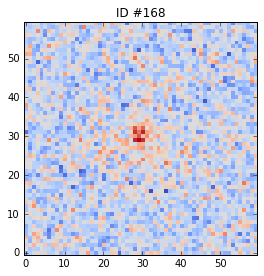

In [80]:
from astropy.table import Table
i = 0
nb_li=60
W = 20*1.25
plt.figure(figsize=(3*5,nb_li*5))
for num_obj in (168,) :#liste_100+liste_50+liste_70+liste_40:

    # Ici : modifier les largeurs S des sous-cubes
    
    try:
        num_cat = np.where(cat_lya['ID']==num_obj)[0][0]
    except:
        print 'erreur obj id %.0f'%num_obj
    ligne_cat = cat_lya[num_cat]
    
    if num_obj in liste_50:
        S = 50
    elif num_obj in liste_40:
        S = 40
    elif num_obj in liste_70:
        S = 70
    elif num_obj in liste_100:
        S = 100
    else:
        S = 60
        
    if num_obj in liste_lam_plus:  
        W = 10*1.25
    #elif num_obj in liste_lam_plus:
    #    W = 10*1.25
    else:
        W = 20*1.25
    
    lbda_reel = (1+ligne_cat['Z_MUSE'])*1216
     
    
    deb = lbda_reel-W/2.
    fin = lbda_reel+W/2.
        
   
    sub_cube_tight = cube.subcube((ligne_cat['DEC'],ligne_cat['RA']),S*0.2,lbda=(deb,fin))#,unit_wave='pixel')
    
    sub_cube_large = cube.subcube((ligne_cat['DEC'],ligne_cat['RA']),S*0.2,lbda=(deb-50,fin+50))
    im_med = sub_cube_large.median(axis=0)
    
    sct_ms = sub_cube_tight.data.data - im_med.data.data[np.newaxis,:,:]
    sub_cube_tight_ms = Cube.new_from_obj(sub_cube_tight,data=sct_ms)
    
    sub_cube_tight_ms.mask = sub_cube_tight.data.mask
    dumb, dumb2 = sub_cube_tight.crop(), sub_cube_tight_ms.crop()
    
    ax = plt.subplot(nb_li,3,i+1)
    im = sub_cube_tight_ms.sum(axis=0)
    im_np = im.data
    plt.imshow(im_np,origin='lower',cmap=plt.cm.coolwarm,interpolation='nearest')
    #im.plot(plt.cm.coolwarm)
    plt.title('ID #'+str(ligne_cat['ID']))
    #ax.set
    i+=1
    
    
    tabz = Table() ; cubes = {};
    tabz['z'] = [ligne_cat['Z_MUSE']]
    cubes['cube'] = sub_cube_tight
    cubes['cube_ms'] = sub_cube_tight_ms

    src = Source.from_data(ID=ligne_cat['ID'],
                          ra = ligne_cat['RA'],
                          dec = ligne_cat['DEC'],
                          origin = ('lyama','0.1','DATACUBE_UDF-10.fits'),
                           z=tabz,
                           cubes=cubes,
                           mask_invalid=False
                           )
    src.write('./data/mosaic_lya_sources/mosaic_'+str(src.id)+'.fits')
    
    

In [58]:
W

15.0

In [22]:
np.where(cat_lya['ID']==num_obj)

(array([], dtype=int64),)

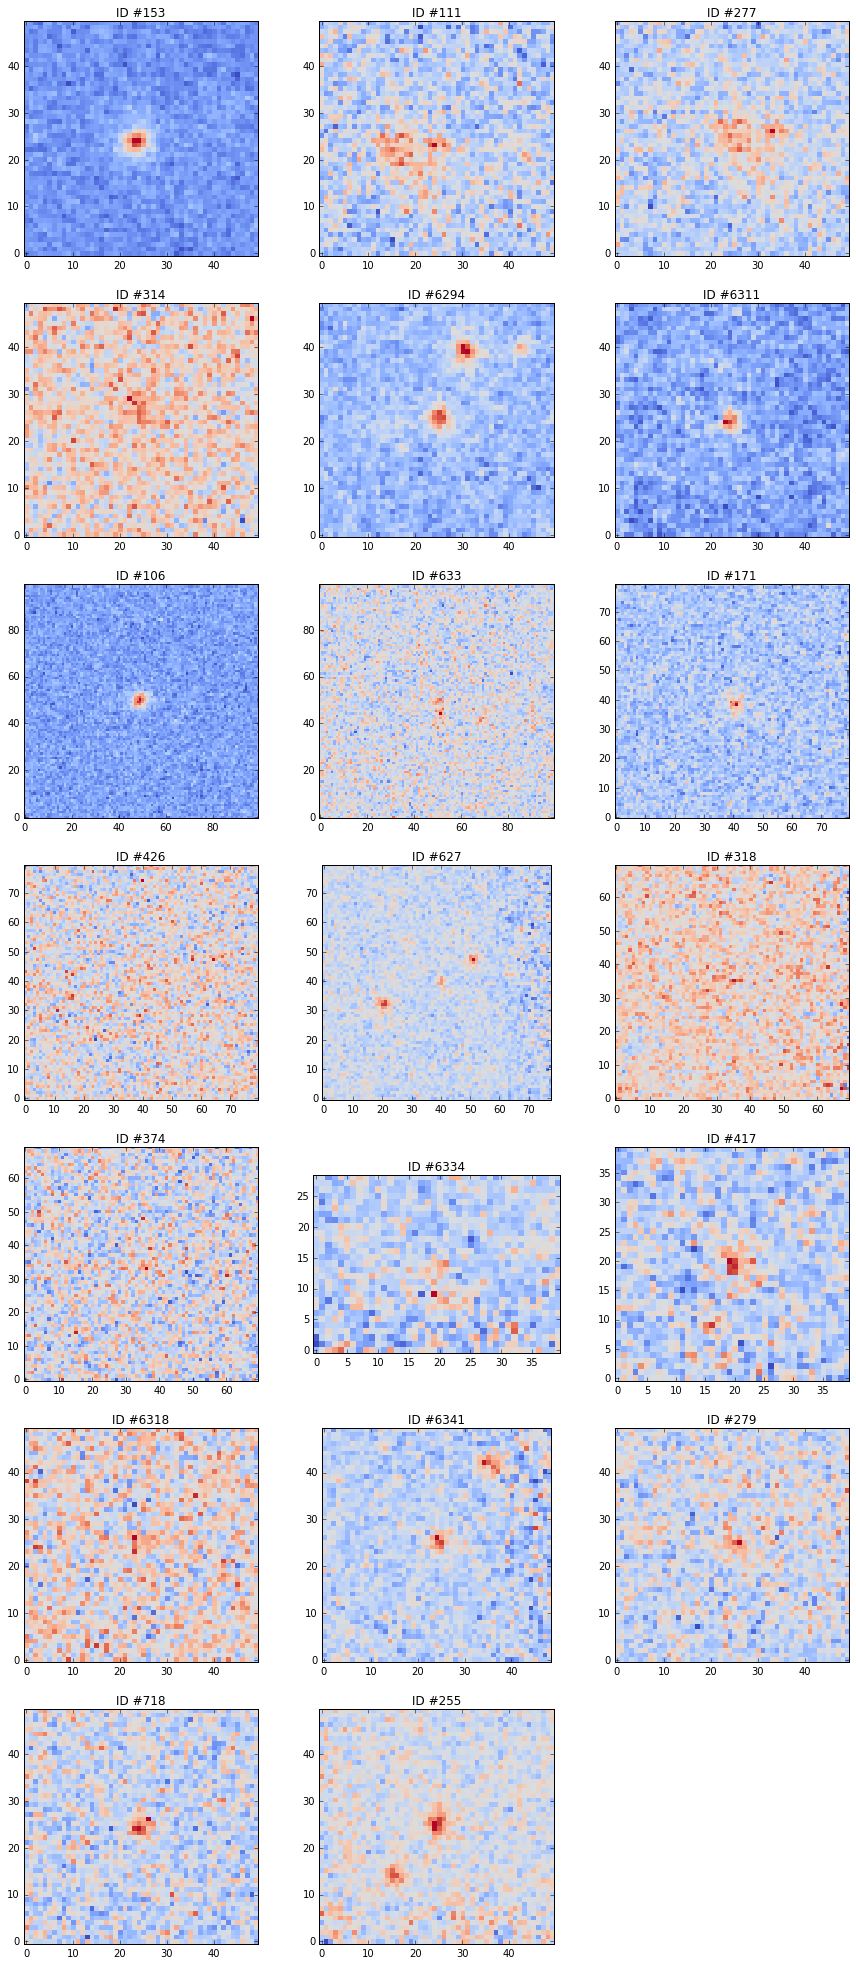

In [35]:
from astropy.table import Table
i = 0
nb_li=20
W = 20*1.25
plt.figure(figsize=(3*5,nb_li*5))
for num_obj in liste_a_proc:#(168,304,321,412,505,510,603,6301,6306,6322,6333,6334,6341,6343,300):#(208,):

    # Ici : modifier les largeurs S des sous-cubes
    
    
    num_cat = np.where(cat['ID']==num_obj)[0][0]
    ligne_cat = cat[num_cat]
    
    listebord_large = (82,97,131,255,430,469,702,6302,6304,6306,6329,6334)
    #
    #if num_obj in (666,459,270,349,406,493,6330,6320,394,6313,533,560,642,149,828,50,357,642,6325,6327,6338,  261,6335,6319,  703,779,338, 6311,214,579,385,6317,718,6294,442,6313,6324, 263,171,605,627,280,705):
    #    S = 80
    #elif num_obj in listebord_large or num_obj in taille80 :
    #    S = 80
    #elif num_obj in (6295,237,183,619,  6335,701,354):
    #    S = 60
    #elif num_obj in (153,78,208,494,308,779,627,385) or num_obj in taille100:
    #    S=100
    #elif num_obj in (157,208):
    #    S=120
    if num_obj in taille50:
        S=50
    elif num_obj in taille35:
        S=35
            
    elif num_obj in taille100:
        S = 100
    elif num_obj in taille80:
        S=80          
    elif num_obj in taille70:
        S=70    
    elif num_obj in taille40:
        S=40   
        
    elif num_obj in taille120:
        S = 120   
    else:
        S = 50
        

    
    lbda_reel = (1+ligne_cat['Z_MUSE'])*1216
    if num_obj==208:
        W = 40.*1.25
    elif num_obj in (547,6295,) :
        W = 12*1.25

    elif num_obj in (6311,6312,802):
        W = 6*1.25
    elif num_obj==802:
        W = 6.*1.25
    else:
        W = 20*1.25
            
    # decalage vers la gauche en wave        
    if num_obj==802:
        deb = lbda_reel-W/2.-3.5*1.25
        fin = lbda_reel+W/2.-3.5*1.25
    elif num_obj in (6311,174,197,319,399,417, 690,701,817,852,690,701,817,852,6325,6317,627, 168,412,) :
        deb = lbda_reel-W/2.-5*1.25
        fin = lbda_reel+W/2.-5*1.25
        
    elif num_obj in (372,426,587,852,666, 6306,6322,6333) :
        deb = lbda_reel-W/2.-10*1.25
        fin = lbda_reel+W/2.-10*1.25 
    elif num_obj==518:
        deb = lbda_reel-W/2.-20*1.25
        fin = lbda_reel+W/2.-20*1.25 
        
    # decalage vers la droite en wavelength
    elif num_obj==6312:
        deb = lbda_reel-W/2.+2*1.25
        fin = lbda_reel+W/2.+2*1.25     
      
    elif num_obj in (125,171,184,228,270, 718,6293,6326,6328, 505,510):
        deb = lbda_reel-W/2.+5*1.25
        fin = lbda_reel+W/2.+5*1.25
        
    elif num_obj in (375,  304,321,603,6301,6341,300) :
        deb = lbda_reel-W/2.+10*1.25
        fin = lbda_reel+W/2.+10*1.25       
        
    # couper des parties
    # la gauche
    elif num_obj in (280,338,417) :
        deb = lbda_reel-W/2.+10*1.25
        fin = lbda_reel+W/2. 
    elif num_obj==837:
        deb = lbda_reel-W/2.+5*1.25
        fin = lbda_reel+W/2. 
    #la droite    
    elif num_obj in (579,651,171,6319,6335):
        deb = lbda_reel-W/2.
        fin = lbda_reel+W/2.-10*1.25
    #les deux
    elif num_obj in (6313,6324, 6343):
        deb = lbda_reel-W/2.+5*1.25
        fin = lbda_reel+W/2.-5*1.25          
    # par defaut    
    else: 
        deb = lbda_reel-W/2.
        fin = lbda_reel+W/2.
        
    if num_obj in lambda_coupe_droite_5:
        fin -= 5*1.25
    elif num_obj in lambda_coupe_droite_gauche_5:
        deb +=5*1.25
        fin -= 5*1.25
    elif num_obj in lambda_plus_7:
        deb +=7*1.25
        fin += 7*1.25
    elif num_obj in lambda_plus_large:
        deb -= W/2
        fin += W/2
    
    sub_cube_tight = cube.subcube((ligne_cat['DEC'],ligne_cat['RA']),S*0.2,lbda=(deb,fin))#,unit_wave='pixel')
    
    sub_cube_large = cube.subcube((ligne_cat['DEC'],ligne_cat['RA']),S*0.2,lbda=(deb-50,fin+50))
    im_med = sub_cube_large.median(axis=0)
    
    sct_ms = sub_cube_tight.data.data - im_med.data.data[np.newaxis,:,:]
    sub_cube_tight_ms = Cube.new_from_obj(sub_cube_tight,data=sct_ms)
    
    #if num_obj in (270,349,406,385,493,459,666,  208,157,50,642,6325,6338, 703,779,338, 214,6294,385,627, 394,6313,533,560,642,280,705,6330,6320): #153,619,828
    #    lmin,lmax = sub_cube_tight.get_range()[0],sub_cube_tight.get_range()[3]
    #    if num_obj==208:
    #        xmin = 20. ;        xmax = 120.
    #        ymin = 10 ;        ymax = 75.
    #
    #    elif num_obj==157:
    #        xmin = 20. ;        xmax = 100.
    #        ymin = 30. ;        ymax = 110.
    #        
    #    elif num_obj==50:
    #        xmin = 0. ;        xmax = 80.
    #        ymin = 10 ;        ymax = 70.
    #    elif num_obj==642:
    #        xmin = 0. ;        xmax = 80.
    #        ymin = 0 ;        ymax = 70.
    #    elif num_obj==6325:
    #        xmin = 0. ;        xmax = 80.
    #        ymin = 22 ;        ymax = 80.
    #    elif num_obj==6338:
    #        xmin = 20. ;        xmax = 80.
    #        ymin = 20 ;        ymax = 70.            
    #    elif num_obj==703:
    #        xmin = 0. ;        xmax = 80.
    #        ymin = 0 ;        ymax = 55.    
    #    elif num_obj==779:
    #        xmin = 0. ;        xmax = 50.
    #        ymin = 15 ;        ymax = 65.    
    #    elif num_obj==338:
    #        xmin = 10. ;        xmax = 70.
    #        ymin = 30. ;        ymax = 80.
    #    elif num_obj==214:
    #        xmin = 0. ;        xmax = 80.
    #        ymin = 0 ;        ymax = 60.
    #        
    #    elif num_obj==6294:
    #        xmin = 0. ;        xmax = 80.
    #        ymin = 20 ;        ymax = 80.
    #    elif num_obj==385:
    #        xmin = 10. ;        xmax = 80.
    #        ymin = 10 ;        ymax = 80.   
    #    elif num_obj==627:
    #        xmin = 00. ;        xmax = 70.
    #        ymin = 0 ;        ymax = 80.        
    #    elif num_obj in (394,6313,533,642,6330,6320): # haut
    #        xmin = 15 ; xmax = 65
    #        ymin = 25; ymax =  75
    #        
    #    elif num_obj in (560,280,705): # bas
    #        xmin = 15; xmax = 65
    #        ymin = 5; ymax = 55
    #        
    #    elif num_obj in (349,406,): # gauche
    #        xmin = 5; xmax = 55
    #        ymin = 15; ymax = 65
    #    elif num_obj in (459,): # gauche ++
    #        xmin = 0; xmax = 50
    #        ymin = 15; ymax = 65            
    #    elif num_obj in (493,): # droite
    #        xmin = 25; xmax = 75
    #        ymin = 15; ymax = 65    
    #    elif num_obj in (666,): # droite
    #        xmin = 15 ; xmax = 65
    #        ymin = 20; ymax =  60          
    #    elif num_obj in (270,): # bas  gauche
    #        xmin = 5; xmax = 55
    #        ymin = 5; ymax = 55
    #        
    #        
    #    coord = [lmin,ymin,xmin,lmax,ymax,xmax]
    #    sub_cube_tight = sub_cube_tight.truncate(coord,unit_wcs=None)
    #    sub_cube_tight_ms = sub_cube_tight_ms.truncate(coord,unit_wcs=None)

    
    sub_cube_tight_ms.mask = sub_cube_tight.data.mask
    dumb, dumb2 = sub_cube_tight.crop(), sub_cube_tight_ms.crop()
    
    ax = plt.subplot(nb_li,3,i+1)
    im = sub_cube_tight_ms.sum(axis=0)
    im_np = im.data
    plt.imshow(im_np,origin='lower',cmap=plt.cm.coolwarm,interpolation='nearest')
    #im.plot(plt.cm.coolwarm)
    plt.title('ID #'+str(ligne_cat['ID']))
    #ax.set
    i+=1
    
    
    tabz = Table() ; cubes = {};
    tabz['z'] = [ligne_cat['Z_MUSE']]
    cubes['cube'] = sub_cube_tight
    cubes['cube_ms'] = sub_cube_tight_ms

    src = Source.from_data(ID=ligne_cat['ID'],
                          ra = ligne_cat['RA'],
                          dec = ligne_cat['DEC'],
                          origin = ('lyama','0.1','DATACUBE_UDF-10.fits'),
                           z=tabz,
                           cubes=cubes,
                           mask_invalid=False
                           )
    src.write('./data/udf10_lya_sources_v0/udf10_'+str(src.id)+'.fits')
    
    

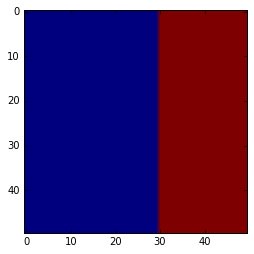

In [26]:
im0 = sub_cube_tight.mean(axis=0)

sub_cube_tight_ms.mask = sub_cube_tight.data.mask
im = sub_cube_tight_ms.mean(axis=0)
plt.imshow(im.mask)

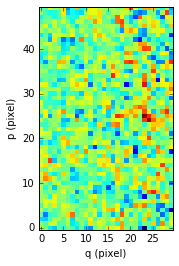

In [28]:
a=sub_cube_tight_ms.crop()
sub_cube_tight_ms.mean(axis=0).plot()


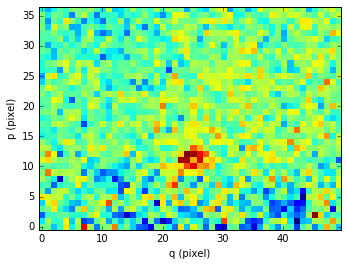

In [18]:
dumb = sub_cube_tight.crop()
sub_cube_tight.mean(axis=(0)).plot()
#print a

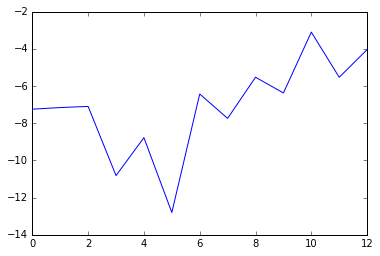

In [57]:
# quelques calsuls sur les res

inten = np.array([0.25,0.25,0.25,0.15,0.25,0.15,0.25,0.15,0.25,0.2,0.5,0.35,0.25])
sigs = np.array([0.5758,0.5700,0.5660,0.5210,0.6868,0.6548,0.5242,0.3657,0.4725,0.4166,0.7147,0.6617,0.3982])
plt.plot(20*np.log10(inten/sigs))

/home/miv/courbot/anaconda/lib/python2.7/site-packages/astropy/stats/lombscargle/implementations/main.py:21: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .cython_impl import lombscargle_cython
/home/miv/courbot/anaconda/lib/python2.7/site-packages/astropy/stats/lombscargle/implementations/main.py:21: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from .cython_impl import lombscargle_cython


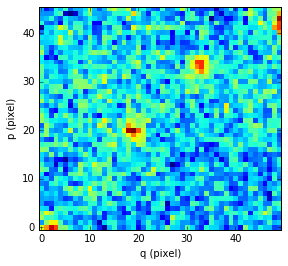

In [9]:
#import astropy.units as Unit

lmin = sub_cube_tight.get_range()[0]
lmax = sub_cube_tight.get_range()[3]

xmin = 10.
xmax = 80

ymin = 10
ymax = 55.

coord = [lmin,ymin,xmin,lmax,ymax,xmax]

scts = sub_cube_tight.truncate(coord,unit_wcs=None)#,mask=False)
scts.sum(axis=0).plot()

In [10]:
scts